In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib.colors as mcolors
import os, csv
import sympy as sym
plt.style.use('ggplot')
%autosave 300

Autosaving every 300 seconds


In [2]:
from __future__ import print_function, division

from sympy import pi, I
from sympy.core.singleton import S
from sympy.core import Dummy, sympify
from sympy.core.function import Function, ArgumentIndexError
from sympy.functions import assoc_legendre
from sympy.functions.elementary.trigonometric import sin, cos, cot
from sympy.functions.combinatorial.factorials import factorial
from sympy.functions.elementary.complexes import Abs
from sympy.functions.elementary.exponential import exp
from sympy.functions.elementary.miscellaneous import sqrt

_x = Dummy("x")

class Ynm(Function):
    r"""
    Spherical harmonics defined as

    .. math::
        Y_n^m(\theta, \varphi) := \sqrt{\frac{(2n+1)(n-m)!}{4\pi(n+m)!}}
                                  \exp(i m \varphi)
                                  \mathrm{P}_n^m\left(\cos(\theta)\right)

    Ynm() gives the spherical harmonic function of order `n` and `m`
    in `\theta` and `\varphi`, `Y_n^m(\theta, \varphi)`. The four
    parameters are as follows: `n \geq 0` an integer and `m` an integer
    such that `-n \leq m \leq n` holds. The two angles are real-valued
    with `\theta \in [0, \pi]` and `\varphi \in [0, 2\pi]`.

    Examples
    ========

    >>> from sympy import Ynm, Symbol
    >>> from sympy.abc import n,m
    >>> theta = Symbol("theta")
    >>> phi = Symbol("phi")

    >>> Ynm(n, m, theta, phi)
    Ynm(n, m, theta, phi)

    Several symmetries are known, for the order

    >>> from sympy import Ynm, Symbol
    >>> from sympy.abc import n,m
    >>> theta = Symbol("theta")
    >>> phi = Symbol("phi")

    >>> Ynm(n, -m, theta, phi)
    (-1)**m*exp(-2*I*m*phi)*Ynm(n, m, theta, phi)

    as well as for the angles

    >>> from sympy import Ynm, Symbol, simplify
    >>> from sympy.abc import n,m
    >>> theta = Symbol("theta")
    >>> phi = Symbol("phi")

    >>> Ynm(n, m, -theta, phi)
    Ynm(n, m, theta, phi)

    >>> Ynm(n, m, theta, -phi)
    exp(-2*I*m*phi)*Ynm(n, m, theta, phi)

    For specific integers n and m we can evalute the harmonics
    to more useful expressions

    >>> simplify(Ynm(0, 0, theta, phi).expand(func=True))
    1/(2*sqrt(pi))

    >>> simplify(Ynm(1, -1, theta, phi).expand(func=True))
    sqrt(6)*exp(-I*phi)*sin(theta)/(4*sqrt(pi))

    >>> simplify(Ynm(1, 0, theta, phi).expand(func=True))
    sqrt(3)*cos(theta)/(2*sqrt(pi))

    >>> simplify(Ynm(1, 1, theta, phi).expand(func=True))
    -sqrt(6)*exp(I*phi)*sin(theta)/(4*sqrt(pi))

    >>> simplify(Ynm(2, -2, theta, phi).expand(func=True))
    sqrt(30)*exp(-2*I*phi)*sin(theta)**2/(8*sqrt(pi))

    >>> simplify(Ynm(2, -1, theta, phi).expand(func=True))
    sqrt(30)*exp(-I*phi)*sin(2*theta)/(8*sqrt(pi))

    >>> simplify(Ynm(2, 0, theta, phi).expand(func=True))
    sqrt(5)*(3*cos(theta)**2 - 1)/(4*sqrt(pi))

    >>> simplify(Ynm(2, 1, theta, phi).expand(func=True))
    -sqrt(30)*exp(I*phi)*sin(2*theta)/(8*sqrt(pi))

    >>> simplify(Ynm(2, 2, theta, phi).expand(func=True))
    sqrt(30)*exp(2*I*phi)*sin(theta)**2/(8*sqrt(pi))

    We can differentiate the functions with respect
    to both angles

    >>> from sympy import Ynm, Symbol, diff
    >>> from sympy.abc import n,m
    >>> theta = Symbol("theta")
    >>> phi = Symbol("phi")

    >>> diff(Ynm(n, m, theta, phi), theta)
    m*cot(theta)*Ynm(n, m, theta, phi) + sqrt((-m + n)*(m + n + 1))*exp(-I*phi)*Ynm(n, m + 1, theta, phi)

    >>> diff(Ynm(n, m, theta, phi), phi)
    I*m*Ynm(n, m, theta, phi)

    Further we can compute the complex conjugation

    >>> from sympy import Ynm, Symbol, conjugate
    >>> from sympy.abc import n,m
    >>> theta = Symbol("theta")
    >>> phi = Symbol("phi")

    >>> conjugate(Ynm(n, m, theta, phi))
    (-1)**(2*m)*exp(-2*I*m*phi)*Ynm(n, m, theta, phi)

    To get back the well known expressions in spherical
    coordinates we use full expansion

    >>> from sympy import Ynm, Symbol, expand_func
    >>> from sympy.abc import n,m
    >>> theta = Symbol("theta")
    >>> phi = Symbol("phi")

    >>> expand_func(Ynm(n, m, theta, phi))
    sqrt((2*n + 1)*factorial(-m + n)/factorial(m + n))*exp(I*m*phi)*assoc_legendre(n, m, cos(theta))/(2*sqrt(pi))

    See Also
    ========

    Ynm_c, Znm

    References
    ==========

    .. [1] http://en.wikipedia.org/wiki/Spherical_harmonics
    .. [2] http://mathworld.wolfram.com/SphericalHarmonic.html
    .. [3] http://functions.wolfram.com/Polynomials/SphericalHarmonicY/
    .. [4] http://dlmf.nist.gov/14.30
    """

    @classmethod
    def eval(cls, n, m, theta, phi):
        n, m, theta, phi = [sympify(x) for x in (n, m, theta, phi)]

        # Handle negative index m and arguments theta, phi
        #if m.could_extract_minus_sign():
        #    m = -m
        #    return S.NegativeOne**m * exp(-2*I*m*phi) * Ynm(n, m, theta, phi)
        if theta.could_extract_minus_sign():
            theta = -theta
            return Ynm(n, m, theta, phi)
        if phi.could_extract_minus_sign():
            phi = -phi
            return exp(-2*I*m*phi) * Ynm(n, m, theta, phi)

        # TODO Add more simplififcation here

    def _eval_expand_func(self, **hints):
        n, m, theta, phi = self.args
        rv = (sqrt((2*n + 1)/(4*pi) * factorial(n - m)/factorial(n + m)) *
                exp(I*m*phi) * assoc_legendre(n, m, cos(theta)))
        # We can do this because of the range of theta
        return rv.subs(sqrt(-cos(theta)**2 + 1), sin(theta))

    def fdiff(self, argindex=4):
        if argindex == 1:
            # Diff wrt n
            raise ArgumentIndexError(self, argindex)
        elif argindex == 2:
            # Diff wrt m
            raise ArgumentIndexError(self, argindex)
        elif argindex == 3:
            # Diff wrt theta
            n, m, theta, phi = self.args
            return (m * cot(theta) * Ynm(n, m, theta, phi) +
                    sqrt((n - m)*(n + m + 1)) * exp(-I*phi) * Ynm(n, m + 1, theta, phi))
        elif argindex == 4:
            # Diff wrt phi
            n, m, theta, phi = self.args
            return I * m * Ynm(n, m, theta, phi)
        else:
            raise ArgumentIndexError(self, argindex)

    def _eval_rewrite_as_polynomial(self, n, m, theta, phi):
        # TODO: Make sure n \in N
        # TODO: Assert |m| <= n ortherwise we should return 0
        return self.expand(func=True)

    def _eval_rewrite_as_sin(self, n, m, theta, phi):
        return self.rewrite(cos)

    def _eval_rewrite_as_cos(self, n, m, theta, phi):
        # This method can be expensive due to extensive use of simplification!
        from sympy.simplify import simplify, trigsimp
        # TODO: Make sure n \in N
        # TODO: Assert |m| <= n ortherwise we should return 0
        term = simplify(self.expand(func=True))
        # We can do this because of the range of theta
        term = term.xreplace({Abs(sin(theta)):sin(theta)})
        return simplify(trigsimp(term))

    def _eval_conjugate(self):
        # TODO: Make sure theta \in R and phi \in R
        n, m, theta, phi = self.args
        return S.NegativeOne**m * self.func(n, -m, theta, phi)

    def as_real_imag(self, deep=True, **hints):
        # TODO: Handle deep and hints
        n, m, theta, phi = self.args
        re = (sqrt((2*n + 1)/(4*pi) * factorial(n - m)/factorial(n + m)) *
              cos(m*phi) * assoc_legendre(n, m, cos(theta)))
        im = (sqrt((2*n + 1)/(4*pi) * factorial(n - m)/factorial(n + m)) *
              sin(m*phi) * assoc_legendre(n, m, cos(theta)))
        return (re, im)

    def _eval_evalf(self, prec):
        # Note: works without this function by just calling
        #       mpmath for Legendre polynomials. But using
        #       the dedicated function directly is cleaner.
        from mpmath import mp, workprec
        from sympy import Expr
        n = self.args[0]._to_mpmath(prec)
        m = self.args[1]._to_mpmath(prec)
        theta = self.args[2]._to_mpmath(prec)
        phi = self.args[3]._to_mpmath(prec)
        with workprec(prec):
            res = mp.spherharm(n, m, theta, phi)
        return Expr._from_mpmath(res, prec)

    def _sage_(self):
        import sage.all as sage
        return sage.spherical_harmonic(self.args[0]._sage_(),
                                       self.args[1]._sage_(),
                                       self.args[2]._sage_(),
                                       self.args[3]._sage_())



In [3]:
class CrystalGroup(object):
    """Class for group character tables"""
    def __init__(self, grp = '', grpcls  = '', irrrep = '', chartab = '', clssize = ''):
        
        GrpLabel = ['C_1','C_i','C_2','C_s','C_2h','D_2','C_2v','D_2h','C_4',
                    'S_4','C_4h','D_4','C_4v','D_2d','D_4h','C_3','S_6','D_3',
                    'C_3v','D_3d','C_6','C_3h','C_6h','D_6','C_6v','D_3h',
                    'D_6h','T','T_h','O','T_d','O_h']
        self.PointGroupNumber = grp
        self.PointGroupLabel = GrpLabel[grp-1]   # Crystallographic point group number
        self.Classes = grpcls     # Classes for resulting group
        self.IrrReps = irrrep # Irreducible representations of group
        self.CharacterTable = chartab # Character table for group
        self.RepresentationDegrees = self.addRepDegrees()
        self.ClassSize = clssize
    
    def addParameterTable(self, elems = '', partab = '', parlab = ''):
        self.Elements = elems
        self.ParameterTable = partab
        self.ParameterLabels = parlab
        self.ElementCharacterTable = self.addElementCharacters()
        self.GroupOrderh = len(elems)
        
    def elementPositions(self):
        #return np.cumsum(self.ClassSize).tolist() #Mathematica
        return (np.insert(np.cumsum(self.ClassSize), 0, 0, axis=0)[0:-1]).tolist()
    
    def addRepDegrees(self):
        return np.array(self.CharacterTable)[:,0].astype(int).tolist()
    
    def addElementCharacters(self):
        elemIdx = self.elementPositions()
        clsSize = np.array(self.ClassSize)-1
        CharTable = np.array(self.CharacterTable)
        for idx in np.arange(len(elemIdx)):
            for elrpt in np.arange(clsSize[idx]):
                CharTable = np.insert(CharTable,elemIdx[idx]+1,CharTable[:,elemIdx[idx]],axis=1)
        return CharTable.tolist()
    
    def addSpaceGroupElements(self, matrix = '', elems = ''):
        self.SpaceGroupMatrices = matrix
        self.SpaceGroupElementNames = elems
        
    def printPointGroup(self):
        return self.PointGroup
        
    def printClasses(self):
        return self.Classes
        
    def printIrrReps(self):
        print(self.IrrReps)
        
    def printCharacterTable(self):
        print(self.CharacterTable)
        
    def printchartable(self):
        null = True
        
class CPGroups(object):
    """Class for all crystallographic point groups"""
    def __init__(self):
        """This will loop through the various folders to import 
        the character and parameter tables for each point group.
        Each point group will form a CrystalGroup class object 
        and these will be joined into a list of class objects."""
        self.Groups = []
        for (dirpath, dirnames, filenames) in os.walk('/'.join([os.getcwd(),'Character Tables'])):
            for file in filenames:
                if file.endswith('.csv'):
                    self.Groups.append(self.ParseCharacterTable(file))
        self.GroupNumbers = []
        for gg in np.arange(len(self.Groups)):
            self.GroupNumbers.append(self.Groups[gg].PointGroupNumber)
            
        for (dirpath, dirnames, filenames) in os.walk('/'.join([os.getcwd(),'Parameter Tables'])):
            for file in filenames:
                if file.endswith('.csv'):
                    GrpIdx = self.GetGroup(int(file.split('_')[1]))
                    Elements, ParameterLabels, ParameterTable = self.ParseParameterTable(file)
                    self.Groups[GrpIdx].addParameterTable(elems = Elements, 
                                                         parlab = ParameterLabels, 
                                                         partab = ParameterTable)
        
        for (dirpath, dirnames, filenames) in os.walk('/'.join([os.getcwd(),'Space Group Elements'])):
            for file in filenames:
                if file.endswith('.csv'):
                    GrpIdx = self.GetGroup(int(file.split('_')[1]))
                    Elements, SpaceGroupTable = self.ParseSpaceGroupTable(file)
                    self.Groups[GrpIdx].addSpaceGroupElements(elems = Elements, 
                                                         matrix = SpaceGroupTable)
        self.SortGroups()
        
    def ParseCharacterTable(self, file):
        """This is a function to parse the formatting of the 
        *CharacterTable_Values.csv files. It will reformat the 
        Mathematica export notation into something a bit simpler.
        From these files the respective group character table, 
        classes, and irreducible representations will be scraped."""
        Group = int(file.split('_')[1])

        with open('/'.join([os.getcwd(),'Character Tables',file])) as csv_file:
            csv_reader = csv.reader(csv_file, delimiter=',')
            line_count = 0
            CharacterTable = []
            IrrRep = []

            for row in csv_reader:
                if line_count == 0:
                    GroupClasses = []
                    for cls in row:
                        if cls == '{}':
                            null = True
                        else:
                            ClsSplit = cls.split('Subscript[')
                            if len(ClsSplit)>1:
                                ClsSplit = '_'.join((ClsSplit[1].split(']'))[0].split(','))
                                ClsSplit = [ClsSplit.replace('"', '').replace(' ','')]
                            ClsSplit = ClsSplit[0].split('Subsuperscript[')
                            if len(ClsSplit)>1:
                                ClsSplit = (ClsSplit[1].split(']'))[0].split(',')
                                ClsSplit = ''.join(['_'.join(ClsSplit[0:2]),'`'])
                                ClsSplit = [ClsSplit.replace('"', '').replace(' ','')]
                            GroupClasses.append(ClsSplit[0])
                    line_count += 1
                elif line_count == 1:
                    ClassSize = []
                    for cls in row:
                        if cls == 'Conjugacy':
                            null = True
                        else:
                            ClassSize.append(int(cls))
                    line_count += 1
                    
                else:
                    TableRow = []
                    colcnt = 0
                    for col in row:
                        if col == '{}':
                            null = True
                        else:
                            RowSplit = col.split('Subscript[')
                            if len(RowSplit)>1:
                                RowSplit = '_'.join((RowSplit[1].split(']'))[0].split(','))
                                RowSplit = [RowSplit.replace('"', '').replace(' ','')]
                            RowSplit = RowSplit[0].split('Subsuperscript[')
                            if len(RowSplit)>1:
                                RowSplit = (RowSplit[1].split(']'))[0].split(',')
                                RowSplit = ''.join(['_'.join(RowSplit[0:2]),'`'])
                                RowSplit = [RowSplit.replace('"', '').replace(' ','')]
                        if colcnt == 0:
                            IrrRep.append(RowSplit[0])
                        else:
                            RowSplit = RowSplit[0].replace('E^','np.exp').replace('I','1j').replace('Pi','np.pi')
                            TableRow.append(eval(RowSplit))
                        colcnt += 1
                    CharacterTable.append(TableRow)
                    line_count += 1

        return CrystalGroup(grp = Group, grpcls = GroupClasses, \
                            irrrep = IrrRep, chartab = CharacterTable, \
                            clssize = ClassSize)
    
    def ParseParameterTable(self, file):
        """This is a function to parse the formatting of the 
        *Parameters.csv files. It will reformat the 
        Mathematica export notation into something a bit simpler.
        From these files the respective group Euler angles, 
        principal angle, and rotation axis will be scraped."""
        Group = int(file.split('_')[1])

        with open('/'.join([os.getcwd(),'Parameter Tables',file])) as csv_file:
            csv_reader = csv.reader(csv_file, delimiter=',')
            line_count = 0
            ParameterTable = []
            Elements = []

            for row in csv_reader:
                if line_count == 0:
                    ParameterLabels = row[1:] 
                    line_count += 1
                else:
                    TableRow = []
                    colcnt = 0
                    for col in row:
                        if col == '{}':
                            null = True
                        else:
                            RowSplit = col.replace('RowBox[{','').split('Subscript[')
                            if len(RowSplit)>1:
                                RowSplit = '_'.join((RowSplit[1].split(']'))[0].split(','))
                                RowSplit = [RowSplit.replace('"', '').replace(' ','')]
                            RowSplit = RowSplit[0].split('Subsuperscript[')
                            if len(RowSplit)>1:
                                RowSplit = (RowSplit[1].split(']'))[0].split(',')
                                RowSplit = ''.join(['_'.join(RowSplit[0:2]),'`'])
                                RowSplit = [RowSplit.replace('"', '').replace(' ','')]
                            
                            tmpSplit = RowSplit[0].split('SqrtBox[')
                            while len(tmpSplit)>1:
                                tmpSplit = [tmpSplit[0],'SqrtBox['.join(tmpSplit[1:])]
                                ttSplit = tmpSplit[1].split(']')
                                ttSplit = [ttSplit[0],']'.join(ttSplit[1:])]
                                tmpSplit = ''.join([tmpSplit[0],'np.sqrt(',ttSplit[0],')',ttSplit[1]])
                                tmpSplit = tmpSplit.split('SqrtBox[')
                            tmpSplit = tmpSplit[0].split('FractionBox[')
                            while len(tmpSplit)>1:
                                tmpSplit = [tmpSplit[0],'FractionBox['.join(tmpSplit[1:])]
                                ttSplit = tmpSplit[1].split(']')
                                ttSplit = ''.join([ttSplit[0].replace(', ','/'),']'.join(ttSplit[1:])])
                                tmpSplit = ''.join([tmpSplit[0],ttSplit])#.replace(', , , ',',')
                                tmpSplit = tmpSplit.split('FractionBox[')
                        if colcnt == 0:
                            Elements.append(RowSplit[0])
                        else:
                            RowSplit = tmpSplit[0].replace('E^','np.exp').replace('I','1j').replace('Pi','np.pi')
                            RowSplit = RowSplit.replace(', , , ',',').replace('{,','[').replace('}','')
                            RowSplit = RowSplit.replace(' ','').replace(',]','').replace(']]',']')
                            RowSplit = RowSplit.replace('-,','-').replace('],',',')
                            TableRow.append(eval(RowSplit))
                        colcnt += 1
                    ParameterTable.append(TableRow)
                    line_count += 1
                    
        return Elements, ParameterLabels, ParameterTable
    
    def ParseSpaceGroupTable(self, file):
        """This is a function to parse the formatting of the 
        *SpaceGroupElements.csv files. It will reformat the 
        Mathematica export notation into something a bit simpler.
        From these files the respective group Euler angles, 
        principal angle, and rotation axis will be scraped."""
        Group = int(file.split('_')[1])

        with open('/'.join([os.getcwd(),'Space Group Elements',file])) as csv_file:
            csv_reader = csv.reader(csv_file, delimiter=',')
            line_count = 0
            SpaceGroupTable = []
            Elements = []

            for row in csv_reader:
                TableRow = []
                colcnt = 0
                for col in row:
                    if col == '{}':
                        null = True
                    else:
                        RowSplit = col.replace('RowBox[{','').split('Subscript[')
                        if len(RowSplit)>1:
                            RowSplit = '_'.join((RowSplit[1].split(']'))[0].split(','))
                            RowSplit = [RowSplit.replace('"', '').replace(' ','')]
                        RowSplit = RowSplit[0].split('Subsuperscript[')
                        if len(RowSplit)>1:
                            RowSplit = (RowSplit[1].split(']'))[0].split(',')
                            RowSplit = ''.join(['_'.join(RowSplit[0:2]),'`'])
                            RowSplit = [RowSplit.replace('"', '').replace(' ','')]

                        tmpSplit = RowSplit[0].split('SqrtBox[')
                        while len(tmpSplit)>1:
                            tmpSplit = [tmpSplit[0],'SqrtBox['.join(tmpSplit[1:])]
                            ttSplit = tmpSplit[1].split(']')
                            ttSplit = [ttSplit[0],']'.join(ttSplit[1:])]
                            tmpSplit = ''.join([tmpSplit[0],'np.sqrt(',ttSplit[0],')',ttSplit[1]])
                            tmpSplit = tmpSplit.split('SqrtBox[')
                        tmpSplit = tmpSplit[0].split('FractionBox[')
                        while len(tmpSplit)>1:
                            tmpSplit = [tmpSplit[0],'FractionBox['.join(tmpSplit[1:])]
                            ttSplit = tmpSplit[1].split(']')
                            ttSplit = ''.join([ttSplit[0].replace(', ','/'),']'.join(ttSplit[1:])])
                            tmpSplit = ''.join([tmpSplit[0],ttSplit])#.replace(', , , ',',')
                            tmpSplit = tmpSplit.split('FractionBox[')
                    if colcnt == 0:
                        Elements.append(RowSplit[0])
                    else:
                        RowSplit = tmpSplit[0].replace('E^','np.exp').replace('I','1j').replace('Pi','np.pi')
                        RowSplit = RowSplit.replace(', , , ',',').replace('{,','[').replace('}','')
                        RowSplit = RowSplit.replace(' ','').replace(',]','').replace(']]',']')
                        RowSplit = RowSplit.replace('-,','-').replace('],',',')
                        TableRow.append(eval(RowSplit))
                    colcnt += 1
                    ParameterTable.append(TableRow)
                    line_count += 1
                    
        return Elements, SpaceGroupTable
    
    def ParseSpaceGroupTable(self, file):
        """This is a function to parse the formatting of the 
        *SpaceGroupElements.csv files. It will reformat the 
        Mathematica export notation into something a bit simpler.
        From these files the respective group Euler angles, 
        principal angle, and rotation axis will be scraped."""
        Group = int(file.split('_')[1])

        with open('/'.join([os.getcwd(),'Space Group Elements',file])) as csv_file:
            csv_reader = csv.reader(csv_file, delimiter=',')
            SpaceGroupTable = []
            Elements = []

            for row in csv_reader:
                RowSplit = row[0].replace('RowBox[{','').split('Subscript[')
                if len(RowSplit)>1:
                    RowSplit = '_'.join((RowSplit[1].split(']'))[0].split(','))
                    RowSplit = [RowSplit.replace('"', '').replace(' ','')]
                RowSplit = RowSplit[0].split('Subsuperscript[')
                if len(RowSplit)>1:
                    RowSplit = (RowSplit[1].split(']'))[0].split(',')
                    RowSplit = ''.join(['_'.join(RowSplit[0:2]),'`'])
                    RowSplit = [RowSplit.replace('"', '').replace(' ','')]

                tmpSplit = RowSplit[0].split('SqrtBox[')
                while len(tmpSplit)>1:
                    tmpSplit = [tmpSplit[0],'SqrtBox['.join(tmpSplit[1:])]
                    ttSplit = tmpSplit[1].split(']')
                    ttSplit = [ttSplit[0],']'.join(ttSplit[1:])]
                    tmpSplit = ''.join([tmpSplit[0],'np.sqrt(',ttSplit[0],')',ttSplit[1]])
                    tmpSplit = tmpSplit.split('SqrtBox[')
                tmpSplit = tmpSplit[0].split('FractionBox[')
                while len(tmpSplit)>1:
                    tmpSplit = [tmpSplit[0],'FractionBox['.join(tmpSplit[1:])]
                    ttSplit = tmpSplit[1].split(']')
                    ttSplit = ''.join([ttSplit[0].replace(', ','/'),']'.join(ttSplit[1:])])
                    tmpSplit = ''.join([tmpSplit[0],ttSplit])#.replace(', , , ',',')
                    tmpSplit = tmpSplit.split('FractionBox[')
                Elements.append(RowSplit[0])

                TableString = ','.join(row[1:]).replace('Sqrt','np.sqrt').replace('[','(').replace(']',')')
                TableString = ''.join(['[',TableString.replace('{','[').replace('}',']'),']'])

                SpaceGroupTable.append(eval(TableString))

        return Elements, SpaceGroupTable

    def GetGroup(self, grpnum):
        return self.GroupNumbers.index(grpnum)
    
    def SortGroups(self):
        import operator
        
        self.Groups.sort(key=operator.attrgetter('PointGroupNumber'))
            
    def PrintGroupList(self):
        for gg in np.arange(len(self.Groups)):
            print(self.Groups[gg].PointGroupNumber,':',self.Groups[gg].PointGroupLabel)

In [4]:
CPG = CPGroups()
CPG.PrintGroupList()

1 : C_1
2 : C_i
3 : C_2
4 : C_s
5 : C_2h
6 : D_2
7 : C_2v
8 : D_2h
9 : C_4
10 : S_4
11 : C_4h
12 : D_4
13 : C_4v
14 : D_2d
15 : D_4h
16 : C_3
17 : S_6
18 : D_3
19 : C_3v
20 : D_3d
21 : C_6
22 : C_3h
23 : C_6h
24 : D_6
25 : C_6v
26 : D_3h
27 : D_6h
28 : T
29 : T_h
30 : O
31 : T_d
32 : O_h


/Users/david/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: ComplexWarning: Casting complex values to real discards the imaginary part


In [5]:
def RYlm(l, m, alpha, beta, gamma, detRot):
    '''This would be rotateHarmonic in the Mathematica code. It is used 
    in the projection of the spherical harmonices to create symmetry
    adapted wavefunctions.
    '''
    from sympy import Symbol
    from sympy import simplify
    
    theta = Symbol("theta", real=True)
    phi = Symbol("phi", real=True)
    
    Rf = 0
    for nn in np.arange(-l,l+0.1):
        nn=int(nn)
        wigD = Wigner_D(l,m,nn,alpha,beta,gamma)
        Rf = Rf + wigD*Ynm(int(l),nn,theta,phi)
    return detRot**l*Rf

def SymmetryAdaptedWF(Group, IrrRep, l, m):
    from sympy import simplify, re, im
    
    # Allows for either string or index input of 
    # the irreducible representation
    if isinstance(IrrRep,str):
        IrrIdx = Group.IrrReps.index(IrrRep)
    else:
        IrrIdx = IrrRep
    
    # Character of the irreducible representation
    chi = Group.CharacterTable[IrrIdx]
    
    # Degree of the irreducible representation which is the same as 
    # the character for the E (identity) element.
    degree = chi[Group.Classes.index('E')]
    
    # Order of the group which is equal to the sum of the elements
    order = len(Group.Elements)
    
    SALC = 0
    EulerCntr = 0
    for sym in np.arange(len(Group.Classes)):
        for clssze in np.arange(Group.ClassSize[sym]):
            # Get the Euler angles (Z-Y-Z) for each class in the group
            alpha = Group.ParameterTable[EulerCntr][0]
            beta = Group.ParameterTable[EulerCntr][1]
            gamma = Group.ParameterTable[EulerCntr][2]
            detRot = Group.ParameterTable[EulerCntr][3]
            #print('alpha = %s, beta = %s, gamma = %s'%(alpha,beta,gamma))
        
            # Will come back to this to either make it more efficient and/or symbolic
            #print('RYlm: %s'%RYlm(l,m,alpha,beta,gamma,detRot))
            #print('chi = ',chi[sym])
            #print('Class Name = %s, Size = %s'%(Group.Classes[sym],Group.ClassSize[sym]))
            SALC = SALC + chi[sym]*RYlm(l,m,alpha,beta,gamma,detRot)
            #print('SALC = %s'%SALC)
            EulerCntr += 1
    
    SALC = simplify(SALC.doit())
    #print('deg = %s, order = %s'%(degree,order))
    #print('chi = ',chi)
    
    CoeffDict = SALC.as_coefficients_dict()
    
    SALC_tmp = 0
    for coeff in CoeffDict.keys():
        if abs(CoeffDict[coeff])<1e-10:
            CoeffDict[coeff] = 0
        SALC_tmp = SALC_tmp + CoeffDict[coeff]*coeff
        
    return degree/order*SALC_tmp

def Wigner_d(j, m1, m2, beta):
    '''
    Inputs :
    
    Outputs 
    '''
    from sympy import factorial, Sum, symbols, cos, sin
    from sympy.abc import k
    
    # The summation over k extends as long as the factorials are positive. 
    # Since one of the factorials is k! then we know that we must start from
    # k=0 and extend to the limit defined below
    k_lim_min = int(np.max([0,m2-m1]))
    k_lim_max = int(np.min([j+m2,j-m1]))
    
    wig_d = (factorial(j+m1)*factorial(j-m1)*factorial(j+m2)*factorial(j-m2))**(1/2)*Sum((-1)**(m1-m2+k)* \
            cos(beta/2)**(2*j+m2-m1-2*k)*sin(beta/2)**(m1-m2+2*k)/(factorial(j+m2-k)* \
            factorial(k)*factorial(m1-m2+k)*factorial(j-m1-k)),(k,k_lim_min,k_lim_max))
    
    return wig_d.doit()

def Wigner_D(j, m1, m2, alpha, beta, gamma, sign_conv = 'Mathematica' ):
    from sympy import simplify, re, im, E, I
    
    if sign_conv == 'Mathematica':
        # Mathematica sign convention
        m1 = -m1
        m2 = -m2
    
    '''print('j:%s, m1:%s, m2:%s, alpha:%s, beta:%s, gamma:%s'%(j, m1, m2, alpha, beta, gamma))
    print(E**(-1j*m1*alpha))
    print(Wigner_d(j, m1, m2, beta)) 
    print(E**(-1j*m2*gamma))'''
    
    WigD = simplify((E**(-I*m1*alpha)*Wigner_d(j, m1, m2, beta)*E**(-I*m2*gamma)).doit())

    if WigD.is_complex:
        WgD = np.array([re(WigD),im(WigD)])
        # This is implemented to remove rounding errors.
        # Should rewrite functions to be symbolic to prevent these errors.
        WgD[abs(WgD)<1e-10] = 0
        WigD = WgD[0]+WgD[1]*1j

    return WigD

In [6]:
# Verify row vs column index
G = 1 # Group Number
for irrp in CPG.Groups[G].IrrReps:
    print('SALCs for %s : %s'%(CPG.Groups[G].PointGroupLabel,irrp))
    for ll in np.arange(0,5):
        for mm in np.arange(-ll,ll+0.1):
            mm = int(mm)
            #print(ll,mm)
            print(SymmetryAdaptedWF(CPG.Groups[G],irrp,ll,mm))
            #print('\n')

SALCs for C_i : A_g
1.0*Ynm(0, 0, theta, phi)
0
0
0
1.0*Ynm(2, -2, theta, phi)
1.0*Ynm(2, -1, theta, phi)
1.0*Ynm(2, 0, theta, phi)
1.0*Ynm(2, 1, theta, phi)
1.0*Ynm(2, 2, theta, phi)
0
0
0
0
0
0
0
1.0*Ynm(4, -4, theta, phi)
1.0*Ynm(4, -3, theta, phi)
1.0*Ynm(4, -2, theta, phi)
1.0*Ynm(4, -1, theta, phi)
1.0*Ynm(4, 0, theta, phi)
1.0*Ynm(4, 1, theta, phi)
1.0*Ynm(4, 2, theta, phi)
1.0*Ynm(4, 3, theta, phi)
1.0*Ynm(4, 4, theta, phi)
SALCs for C_i : A_u
0
1.0*Ynm(1, -1, theta, phi)
1.0*Ynm(1, 0, theta, phi)
1.0*Ynm(1, 1, theta, phi)
0
0
0
0
0
1.0*Ynm(3, -3, theta, phi)
1.0*Ynm(3, -2, theta, phi)
1.0*Ynm(3, -1, theta, phi)
1.0*Ynm(3, 0, theta, phi)
1.0*Ynm(3, 1, theta, phi)
1.0*Ynm(3, 2, theta, phi)
1.0*Ynm(3, 3, theta, phi)
0
0
0
0
0
0
0
0
0


Looks like we are reproducing the same symmetry adapted functions as the Mathematica code. Huzzah!

Now, let us move on to the crystal field potential.

In [7]:
def B_CF(ll,mm):
    '''
    Generates a symbol placeholder for the B coefficients in the crystal field potential.
    '''
    from sympy import symbols
    if mm<0:
        Bcf = (-1)**mm*symbols(''.join(['B_',str(ll),str(abs(mm))]))
    else:
        Bcf = symbols(''.join(['B_',str(ll),str(mm)]))
    return Bcf

def C_CF(ll,mm):
    '''
    Function to add the prefactor for the unnormalized spherical 
    harmonics used in the crystal field potential.
    '''
    return np.sqrt(4*np.pi/(2*ll+1))*Ylm(ll,mm)

def GetSALCs(Group,IrrRep,l_max):
    '''
    Function to get all of the symmetry adapted functions for a given 
    representation (IrrRep) of a given group (Group) up to a
    maximum l value (l_max)
    '''
    SALCs = []
    for ll in np.arange(1,l_max+0.1):
        for mm in np.arange(-ll,ll+0.1):
            SALCs.append(SymmetryAdaptedWF(Group,IrrRep,ll,mm))
    return np.array(SALCs)

def RealCheck(SALCs, debug = False):
    '''
    Ideally we would require that the B coefficients be real.
    Thus, if the C terms are imaginary then the corresponding 
    B would also be imaginary. However, we can pull the value i
    out from the B, so that it remains real and instead we
    multiply the C by i.
    '''
    from sympy import re, im
    realness = np.ones((len(SALCs),),dtype=complex)
    for salc in np.arange(len(SALCs)):
        ExpSALC = SALCs[salc].rewrite(cos).simplify()
        if debug == True:
            print(ExpSALC, re(ExpSALC))
        if (re(ExpSALC) == 0): 
            realness[salc] = 1j
        else:
            
            realness[salc] = 1
    return realness

def SALC_SymTest(SALCs):
    '''
    Function to test for a
    '''
    for salc in np.arange(len(SALCs)):
        mask = SALCs == -SALCs[salc]
        mask[0:salc] = 0
        SALCs[mask] = -SALCs[mask]
    return SALCs

def GenerateBList(PointGroupNumber, l):
    Blist = []
    Bcoeff = []
    IdxList = []
    for ll in np.arange(1,l+0.1):
        ll = int(ll)
        for mm in np.arange(-ll,ll+0.1):
            mm = int(mm)
            IdxList.append([ll,mm])
            if PointGroupNumber >= 28:
                if ll == 4 and (abs(mm) == 4):
                    Bcoeff.append(np.sqrt(5/14))
                    Blist.append(B_CF(ll,0))
                elif ll == 6 and (abs(mm) == 4):
                    Bcoeff.append(np.sqrt(7/2))
                    Blist.append(B_CF(ll,0))
                else:
                    if mm<0:
                        Bcoeff.append((-1)**mm)
                    else:
                        Bcoeff.append(1)
                    Blist.append(B_CF(ll,abs(mm)))
            else:
                if mm<0:
                    #Bcoeff.append(1) #Jon's Code
                    Bcoeff.append((-1)**mm)
                else:
                    Bcoeff.append(1)
                Blist.append(B_CF(ll,abs(mm)))
    IdxList = np.array(IdxList)
    RepeatIdx = IdxList[:,1]>0
    IdxList = CompareBlist(IdxList)
    IdxList[:,RepeatIdx] = 0
    NormList = IdxList/np.expand_dims(IdxList.sum(axis=0),axis=1).dot(np.ones((1,IdxList.shape[1]))).T
    NormList[np.isnan(NormList)] = 0
    NormList[np.isinf(NormList)] = 0
    
    Bcoeff = np.array(Bcoeff)
    Blist = np.array(Blist)
    
    return Bcoeff, Blist, IdxList, NormList

def CFP(Group,l=4, debug=False, as_Ckq=False):
    '''
    Generates the crystal field potential for the group \
    out to angular momentum l=4.
    '''
    
    SALCs = GetSALCs(Group,0,l)
    
    Bcoeff, Blist, IdxList, NormList = GenerateBList(Group.PointGroupNumber, l)
    
    Sym_SALCs = SALC_SymTest(Bcoeff*SALCs).dot(IdxList)
    Real_SALCs = RealCheck((Sym_SALCs).dot(IdxList),debug)
    
    V_CF = (Sym_SALCs*Real_SALCs).dot(Blist.dot(NormList))
    CoeffDict = V_CF.as_coefficients_dict()
    Vcf_tmp = 0
    for coeff in CoeffDict.keys():
        if abs(CoeffDict[coeff])<1e-7:
            CoeffDict[coeff] = 0
        Vcf_tmp = Vcf_tmp + CoeffDict[coeff]*coeff
    
    if debug == True:
        print('SALCs')
        print(SALCs)
    
        print('Realness')
        print(Real_SALCs)
    
        print('Symmetry')
        print(Sym_SALCs)
    
    V_CF = Vcf_tmp.simplify()
    
    if as_Ckq == True:
        V_CF = V_CF.replace(Ynm,Ckq)
    return V_CF

def Ckq(k,q,theta,phi):
    from sympy import Symbol
    return Symbol(''.join(['C_{',str(k),str(q),'}']))


def CompareBlist(Blist):
    len_Blist = len(Blist)
    mask = np.zeros((len_Blist,len_Blist))
    for idx in np.arange(len_Blist):
        mask[idx,:] = (Blist[idx,0]==abs(Blist[:,0]))*(abs(Blist[idx,1])==abs(Blist[:,1]))
    return mask

Want to check how many SALCs are real, imaginary, or complex. This is to help inform the validity of multiplying the SALCs by i in order to make the prefactor be real. 

In [8]:
'''from sympy import re, im, Abs
for grp in np.arange(32):
    SALCs = GetSALCs(CPG.Groups[grp],0,4)
    print(CPG.Groups[grp].PointGroupLabel)
    Bcoeff, Blist, IdxList, NormList = GenerateBList(CPG.Groups[grp].PointGroupNumber, 4)
    SALClist = SALC_SymTest(SALCs).dot(IdxList)
    for salc in np.arange(len(SALClist)):
        ExpSALC = SALClist[salc].rewrite(cos).simplify()
        ReSALC = re(ExpSALC).simplify()
        ImSALC = im(ExpSALC).simplify()
        if (ReSALC != 0) and (Abs(ImSALC) < 1E-10):
            print('Real')

        elif (abs(ReSALC)  < 1E-10) and (ImSALC != 0):
            print('Imaginary')

        elif (abs(ReSALC) >  1E-10) and (Abs(ImSALC)  > 1E-10):
            print('Complex')

        else:
            print('Zero')'''

"from sympy import re, im, Abs\nfor grp in np.arange(32):\n    SALCs = GetSALCs(CPG.Groups[grp],0,4)\n    print(CPG.Groups[grp].PointGroupLabel)\n    Bcoeff, Blist, IdxList, NormList = GenerateBList(CPG.Groups[grp].PointGroupNumber, 4)\n    SALClist = SALC_SymTest(SALCs).dot(IdxList)\n    for salc in np.arange(len(SALClist)):\n        ExpSALC = SALClist[salc].rewrite(cos).simplify()\n        ReSALC = re(ExpSALC).simplify()\n        ImSALC = im(ExpSALC).simplify()\n        if (ReSALC != 0) and (Abs(ImSALC) < 1E-10):\n            print('Real')\n\n        elif (abs(ReSALC)  < 1E-10) and (ImSALC != 0):\n            print('Imaginary')\n\n        elif (abs(ReSALC) >  1E-10) and (Abs(ImSALC)  > 1E-10):\n            print('Complex')\n\n        else:\n            print('Zero')"

In [9]:
'''for grp in np.arange(32):
    SALCs = GetSALCs(CPG.Groups[grp],0,4)
    print(CPG.Groups[grp].PointGroupLabel)
    
    Bcoeff, Blist, IdxList, NormList = GenerateBList(CPG.Groups[grp].PointGroupNumber, 4)
    
    SALClist = (Bcoeff*SALCs).dot(IdxList)
        
    V_CF = SALClist.dot(Blist.dot(NormList))
    
    CoeffDict = V_CF.as_coefficients_dict()
    Vcf_tmp = 0
    for coeff in CoeffDict.keys():
        if abs(CoeffDict[coeff])<1e-10:
            CoeffDict[coeff] = 0
        Vcf_tmp = Vcf_tmp + CoeffDict[coeff]*coeff
    
    print(Vcf_tmp)'''

'for grp in np.arange(32):\n    SALCs = GetSALCs(CPG.Groups[grp],0,4)\n    print(CPG.Groups[grp].PointGroupLabel)\n    \n    Bcoeff, Blist, IdxList, NormList = GenerateBList(CPG.Groups[grp].PointGroupNumber, 4)\n    \n    SALClist = (Bcoeff*SALCs).dot(IdxList)\n        \n    V_CF = SALClist.dot(Blist.dot(NormList))\n    \n    CoeffDict = V_CF.as_coefficients_dict()\n    Vcf_tmp = 0\n    for coeff in CoeffDict.keys():\n        if abs(CoeffDict[coeff])<1e-10:\n            CoeffDict[coeff] = 0\n        Vcf_tmp = Vcf_tmp + CoeffDict[coeff]*coeff\n    \n    print(Vcf_tmp)'

In [8]:
from sympy import symbols, latex
theta, phi = symbols('\Theta \phi')
from IPython.display import HTML, display, Math, Latex

def fmt_table(data,center_data=False,add_row_nums=False):
    from math import ceil
    buf='''
\\newcommand\\T{\\Rule{0pt}{1em}{.3em}}
\\begin{array}{%s}    
'''
    max_cols = max(len(r) for r in data)
    column_spec = '|' + '|'.join(['c']*max_cols) + '|'
    buf = buf % column_spec
    row_idx = 0
    for row_data in data:
        row = ''
        if add_row_nums and row_idx > 0:
            row += str(row_idx) + " & "
        if center_data and row_idx > 0:
            to_add = ceil( (max_cols - len(row_data))/2 )
            row += ' & '.join([''] * to_add)
        row += ' & '.join(row_data)
        if row_idx == 0:
            row = '''\\hline''' + row + '''\\\\\hline'''
        else:
            row += '''\\\\\hline'''
        row += "\n"
        buf +=row
        row_idx += 1
    buf += '''\\end{array}'''
    # print(buf)
    return buf
'''    
l = 4
tbl = []
tbl.append(['\\texttt{Group}','V_{CF}'])
for grp in np.arange(32):
    row = []
    SALCs = GetSALCs(CPG.Groups[grp],0,l)
    if len(CPG.Groups[grp].PointGroupLabel.split('_'))>1:
        row.append(''.join(['_{'.join(CPG.Groups[grp].PointGroupLabel.split('_')),'}']))
    else:
        row.append(CPG.Groups[grp].PointGroupLabel)
    
    Bcoeff, Blist, IdxList, NormList = GenerateBList(CPG.Groups[grp].PointGroupNumber, l)
    
    Sym_SALCs = SALC_SymTest(Bcoeff*SALCs).dot(IdxList)
    Real_SALCs = RealCheck((Sym_SALCs).dot(IdxList))
        
    V_CF = (Sym_SALCs*Real_SALCs).dot(Blist.dot(NormList))
    
    CoeffDict = V_CF.as_coefficients_dict()
    Vcf_tmp = 0
    for coeff in CoeffDict.keys():
        if abs(CoeffDict[coeff])<1e-7:
            CoeffDict[coeff] = 0
        Vcf_tmp = Vcf_tmp + CoeffDict[coeff]*coeff
    
    row.append(latex(Vcf_tmp))

    tbl.append(row)
    

display(Math(fmt_table(tbl,add_row_nums=False,center_data=True)))'''

"    \nl = 4\ntbl = []\ntbl.append(['\\texttt{Group}','V_{CF}'])\nfor grp in np.arange(32):\n    row = []\n    SALCs = GetSALCs(CPG.Groups[grp],0,l)\n    if len(CPG.Groups[grp].PointGroupLabel.split('_'))>1:\n        row.append(''.join(['_{'.join(CPG.Groups[grp].PointGroupLabel.split('_')),'}']))\n    else:\n        row.append(CPG.Groups[grp].PointGroupLabel)\n    \n    Bcoeff, Blist, IdxList, NormList = GenerateBList(CPG.Groups[grp].PointGroupNumber, l)\n    \n    Sym_SALCs = SALC_SymTest(Bcoeff*SALCs).dot(IdxList)\n    Real_SALCs = RealCheck((Sym_SALCs).dot(IdxList))\n        \n    V_CF = (Sym_SALCs*Real_SALCs).dot(Blist.dot(NormList))\n    \n    CoeffDict = V_CF.as_coefficients_dict()\n    Vcf_tmp = 0\n    for coeff in CoeffDict.keys():\n        if abs(CoeffDict[coeff])<1e-7:\n            CoeffDict[coeff] = 0\n        Vcf_tmp = Vcf_tmp + CoeffDict[coeff]*coeff\n    \n    row.append(latex(Vcf_tmp))\n\n    tbl.append(row)\n    \n\ndisplay(Math(fmt_table(tbl,add_row_nums=False,center_d

Let's assume we get this crystal field potential figured out. Then we need to use Clebsch-Gordon coefficients to diagonalize this interaction to determine how the levels split. 

Here is what is done in Mathematica:

oneElectronSplitting::usage = 
  "oneElectronSplitting[G] finds the energy level splitting for a \
single d-electron in a crystal field with the symmetry of point group \
G";

oneElectronSplitting[G_] := 
  oneElectronSplitting[G] = 
   Module[{eSys, eVals, eVecs, reps}, 
    eSys = Eigensystem[
      Table[CFP[G, 4] /. 
        c[l_, m_] :> 
         threeHarmonicIntegrate[2, m1, l, m, 2, m2], {m1, -2, 
        2}, {m2, -2, 2}]]; eVals = eSys[[1]];
    eVecs = 
     Map[#.{Global`Y[2, -2], Global`Y[2, -1], Global`Y[2, 0], 
         Global`Y[2, 1], Global`Y[2, 2]} &, eSys[[2]]];
    reps = 
     Flatten[Map[nonZeroPositions, 
       Table[Simplify[
         eVecs[[ll]] /. 
          Global`Y[l_, m_] :> 
           Table[rotateHarmonic @@ 
              Join[{l, m}, 
               eulerAnglesZYZ[G][[nn, 
                 2]], {eulerAnglesZYZ[G][[nn, 1]]}], {nn, 1, 
              Length[eulerAnglesZYZ[G][[All, 2]]]}].elementCharacters[
              G][[mm]]], {ll, 1, Length[eVecs]}, {mm, 1, 
         Length[representations\[CapitalGamma][G]]}]]]; 
    SortBy[Transpose[{eVecs, eVals, reps}], Last]];
    
threeHarmonicIntegrate::usage = 
  "threeHarmonicIntegrate[l,m,k,q,lp,mp] solve the integral of \
the product of three spherical harmonics (i.e., eqn 1.15 from  STK) where one is unnormalized";

(*threeHarmonicIntegrate[l1_, m1_, l2_, m2_, l3_, m3_] := 
  Sqrt[(2 l1 + 1)/(2 l3 + 1)]ClebschGordan[{l3, 0}, {l2, 0}, {l1, 0}] ClebschGordan[{l3, m3}, {l2, m2}, {l1, m1}];*)
  threeHarmonicIntegrate[l_, m_, k_, q_, lp_, mp_] := 
  Sqrt[(2 l + 1)/(2 lp + 1)] ClebschGordan[{k, 0}, {lp, 0}, {l, 0}] ClebschGordan[{k, q}, {lp, mp}, {l, m}];


In [9]:
def Ckq2THI(l,m,theta,phi):
    return ThreeHarmonicIntegrate(l1, m1, l, m, l3, m3)

def ThreeHarmonicIntegrate(l1, m1, l2, m2, l3, m3):
    '''
    ThreeHarmonicIntegrate(l1,m1,l2,m2,l3,m3) solves the integral of 
    the product of three spherical harmonics (i.e., eqn 1.15 from  STK) where
    one is unnormalized. This is used in the determination of the single
    electron crystal field splitting.
    
    l1 : l quantum number of orbital 1 (Y_l1,m1) [l in STK notation]
    l3 : l quantum number of orbital 2 (Y_l3,m3) [l' in STK notation]
    m1 : m quantum number of l1 [-l1,-l1+1,...,l1-1,l1] [m in STK notation]
    m3 : m quantum number of l3 [-l3,-l3+1,...,l3-1,l3] [m' in STK notation]
    
    l2 : k in STK notation [ |l-l'|<=k<=l+l' ] 
    m2 : q in STK notation [ q = m-m' ]
    '''
    from sympy.physics.quantum.cg import CG
    from sympy import sqrt
    THI = sqrt((2*l1+1)/(2*l3+1))*CG(l2,0,l3,0,l1,0)*CG(l2,m2,l3,m3,l1,m1)
    return THI

def SingleElectronSplitting(Group, l=4, orbital = 'd', debug=False):
    '''
    ----------------------------
    | orbitals | s | p | d | f |
    ----------------------------
    |    l     | 0 | 1 | 2 | 3 |
    ----------------------------
    Note that this is currently only valid for intra-orbital 
    '''
    from sympy import Symbol, Matrix, simplify
    
    if isinstance(orbital,str):
        if orbital == 's':
            orbital = 0
        elif orbital == 'p':
            orbital = 1
        elif orbital == 'd':
            orbital = 2
        elif orbital == 'f':
            orbital = 3
        else:
            print('ERROR: Orbital does not exist! Please choose one of s,p,d, or f orbitals')
    
    global l1, m1, l3, m3
    
    l1 = Symbol('l1')
    m1 = Symbol('m1')
    l3 = Symbol('l3')
    m3 = Symbol('m3')
    
    
    
    CFP_Table = []
    THI_func = CFP(Group,l=4).replace(Ynm,Ckq2THI)
    
    for mm1 in np.arange(-orbital,orbital+0.1):
        mm1 = int(mm1)
        col_tmp = []
        for mm3 in np.arange(-orbital,orbital+0.1):
            mm3 = int(mm3)
            col_tmp.append(THI_func.subs([(l1, orbital), (m1,mm1), (l3, orbital), (m3,mm3)]).simplify())
        CFP_Table.append(col_tmp)
        
    del l1, m1, l3, m3
    
    EigenSys = Matrix(CFP_Table).eigenvects()
    EigenVals = []
    EigenVecs = []
    for eRes in EigenSys:
        for deg in np.arange(eRes[1]):
            EigenVals.append(eRes[0])
            EigenVecs.append(list(eRes[2][deg]))
            
    Yarray = []
    for mm in np.arange(-orbital,orbital+0.1):
        Yarray.append(Ynm(2,int(mm),theta,phi))
    Yarray = Matrix(Yarray)
    EigenVecs = Matrix(EigenVecs)
    
    global alpha, beta, gamma, detRot
    
    eVec = list(EigenVecs*Yarray)
    reps = []
    ParTable = Group.ParameterTable
    for evc in eVec:
        rotEVecs = []
        
        for rep in np.arange(len(ParTable)):
            alpha = ParTable[rep][0]
            beta = ParTable[rep][1]
            gamma = ParTable[rep][2]
            detRot = ParTable[rep][3]
            rotEVecs.append(evc.replace(Ynm,Yrot))
        reps.append(np.array(Group.ElementCharacterTable).dot(np.array(rotEVecs)).tolist())
        
    repIdx = []
    for row in reps:
        rowsimp = []
        for col in row:
            colsimp = simplify(col)
            CoeffDict = colsimp.as_coefficients_dict()
    
            col_tmp = 0
            for coeff in CoeffDict.keys():
                
                if abs(CoeffDict[coeff])<1e-10:
                    CoeffDict[coeff] = 0
                col_tmp = col_tmp + CoeffDict[coeff]*coeff
            rowsimp.append(col_tmp)
        
        repIdx.append([idx for idx, val in enumerate(rowsimp) if val != 0][0]) 
    
    '''if debug == True:
        for row in reps:
            for col in row:
                print(simplify(col))'''
                
    srtIdx = np.array(repIdx).argsort().tolist()
    return EigenVals, eVec, repIdx, srtIdx

def Yrot(l,m,theta,phi):
    return RYlm(l, m, alpha, beta, gamma, detRot)

Think I might want to go back and make some of the coefficients to be symbolic instead of floats. I believe this will help to minimize rounding errors.

The next step is to find the representations that the eigenvectors belong to.

This is now finished. It looks like oneElectronSplitting is used to calculate two things: 1) physicalEigenvectors and 2) representationEnergy

However, first it looks like we need to construct products of components in different representations. We'll do this by working our way through the Mathematica notebook "Issues_with_CFP_and_Physical_Basis.nb"

In [10]:
for grp in np.arange(8,32):
    print('===================================================')
    print('Group %s: %s'%(grp+1,CPG.Groups[grp].PointGroupLabel))
    print('===================================================')
    eVals, eVecs, reps, srtIdx = SingleElectronSplitting(CPG.Groups[grp], l=4, orbital = 'd',debug=True)
    print('Eigenvectors')
    print('------------')
    print(eVecs)
    print('\n')
    print('Eigenvalues')
    print('------------')
    print(eVals)
    print('\n')
    print('Representations')
    print('---------------')
    for idx in reps:
        print(CPG.Groups[grp].IrrReps[idx])
    print('\n \n')

Group 9: C_4


/Users/david/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:95: RuntimeWarning: invalid value encountered in true_divide


Eigenvectors
------------
[1.0*Ynm(2, 0, \Theta, \phi), 1.0*Ynm(2, -1, \Theta, \phi), 1.0*Ynm(2, 1, \Theta, \phi), -1.0*Ynm(2, -2, \Theta, \phi) + 1.0*Ynm(2, 2, \Theta, \phi), 1.0*Ynm(2, -2, \Theta, \phi) + 1.0*Ynm(2, 2, \Theta, \phi)]


Eigenvalues
------------
[0.285714285714286*B_20 + 0.285714285714286*B_40, 0.142857142857143*B_20 - 0.19047619047619*B_40, 0.142857142857143*B_20 - 0.19047619047619*B_40, -0.285714285714286*B_20 + 0.0476190476190476*B_40 - 0.398409536444798*B_44, -0.285714285714286*B_20 + 0.0476190476190476*B_40 + 0.398409536444798*B_44]


Representations
---------------
A
E_1
E_2
B
B

 

Group 10: S_4


/Users/david/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:95: RuntimeWarning: invalid value encountered in true_divide


Eigenvectors
------------
[1.0*Ynm(2, 0, \Theta, \phi), 1.0*Ynm(2, -1, \Theta, \phi), 1.0*Ynm(2, 1, \Theta, \phi), -1.0*Ynm(2, -2, \Theta, \phi) + 1.0*Ynm(2, 2, \Theta, \phi), 1.0*Ynm(2, -2, \Theta, \phi) + 1.0*Ynm(2, 2, \Theta, \phi)]


Eigenvalues
------------
[0.285714285714286*B_20 + 0.285714285714286*B_40, 0.142857142857143*B_20 - 0.19047619047619*B_40, 0.142857142857143*B_20 - 0.19047619047619*B_40, -0.285714285714286*B_20 + 0.0476190476190476*B_40 - 0.398409536444798*B_44, -0.285714285714286*B_20 + 0.0476190476190476*B_40 + 0.398409536444798*B_44]


Representations
---------------
A
E_2
E_1
B
B

 

Group 11: C_4h
Eigenvectors
------------
[1.0*Ynm(2, 0, \Theta, \phi), 1.0*Ynm(2, -1, \Theta, \phi), 1.0*Ynm(2, 1, \Theta, \phi), -1.0*Ynm(2, -2, \Theta, \phi) + 1.0*Ynm(2, 2, \Theta, \phi), 1.0*Ynm(2, -2, \Theta, \phi) + 1.0*Ynm(2, 2, \Theta, \phi)]


Eigenvalues
------------
[0.285714285714286*B_20 + 0.285714285714286*B_40, 0.142857142857143*B_20 - 0.19047619047619*B_40, 0.142857142

KeyboardInterrupt: 

In [12]:
for grp in np.arange(8,32):
    print('===================================================')
    print('Group %s: %s'%(grp+1,CPG.Groups[grp].PointGroupLabel))
    print('===================================================')
    eVals, eVecs, reps, srtIdx = SingleElectronSplitting(CPG.Groups[grp], l=4, orbital = 'd',debug=True)
    print('Eigenvectors')
    print('------------')
    print(eVecs)
    print('\n')
    print('Eigenvalues')
    print('------------')
    print(eVals)
    print('\n')
    print('Representations')
    print('---------------')
    for idx in reps:
        print(CPG.Groups[grp].IrrReps[idx])
    print('\n \n')

Group 9: C_4


/Users/DodsonWork/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:95: RuntimeWarning: invalid value encountered in true_divide


Eigenvectors
------------
[1.0*Ynm(2, -1, \Theta, \phi), 1.0*Ynm(2, 1, \Theta, \phi), 1.0*Ynm(2, 0, \Theta, \phi), -1.0*Ynm(2, -2, \Theta, \phi) + 1.0*Ynm(2, 2, \Theta, \phi), 1.0*Ynm(2, -2, \Theta, \phi) + 1.0*Ynm(2, 2, \Theta, \phi)]


Eigenvalues
------------
[0.142857142857143*B_20 - 0.19047619047619*B_40, 0.142857142857143*B_20 - 0.19047619047619*B_40, 0.285714285714286*B_20 + 0.285714285714286*B_40, -0.285714285714286*B_20 + 0.0476190476190476*B_40 - 0.398409536444798*B_44, -0.285714285714286*B_20 + 0.0476190476190476*B_40 + 0.398409536444798*B_44]


Representations
---------------
E_1
E_2
A
B
B

 

Group 10: S_4


/Users/DodsonWork/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:95: RuntimeWarning: invalid value encountered in true_divide


Eigenvectors
------------
[1.0*Ynm(2, -1, \Theta, \phi), 1.0*Ynm(2, 1, \Theta, \phi), 1.0*Ynm(2, 0, \Theta, \phi), -1.0*Ynm(2, -2, \Theta, \phi) + 1.0*Ynm(2, 2, \Theta, \phi), 1.0*Ynm(2, -2, \Theta, \phi) + 1.0*Ynm(2, 2, \Theta, \phi)]


Eigenvalues
------------
[0.142857142857143*B_20 - 0.19047619047619*B_40, 0.142857142857143*B_20 - 0.19047619047619*B_40, 0.285714285714286*B_20 + 0.285714285714286*B_40, -0.285714285714286*B_20 + 0.0476190476190476*B_40 - 0.398409536444798*B_44, -0.285714285714286*B_20 + 0.0476190476190476*B_40 + 0.398409536444798*B_44]


Representations
---------------
E_2
E_1
A
B
B

 

Group 11: C_4h
Eigenvectors
------------
[1.0*Ynm(2, -1, \Theta, \phi), 1.0*Ynm(2, 1, \Theta, \phi), 1.0*Ynm(2, 0, \Theta, \phi), -1.0*Ynm(2, -2, \Theta, \phi) + 1.0*Ynm(2, 2, \Theta, \phi), 1.0*Ynm(2, -2, \Theta, \phi) + 1.0*Ynm(2, 2, \Theta, \phi)]


Eigenvalues
------------
[0.142857142857143*B_20 - 0.19047619047619*B_40, 0.142857142857143*B_20 - 0.19047619047619*B_40, 0.2857142857

KeyboardInterrupt: 

This agrees with the table in the notebook.
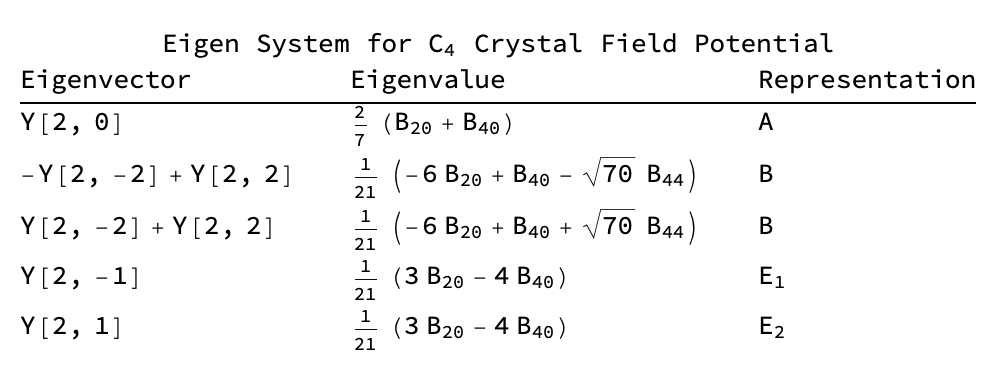

Now we will determine if a given group is able to accommodate the d-orbital basis together with the level splittings and degrees of the group.

Here's the table from Mathematica for reference:

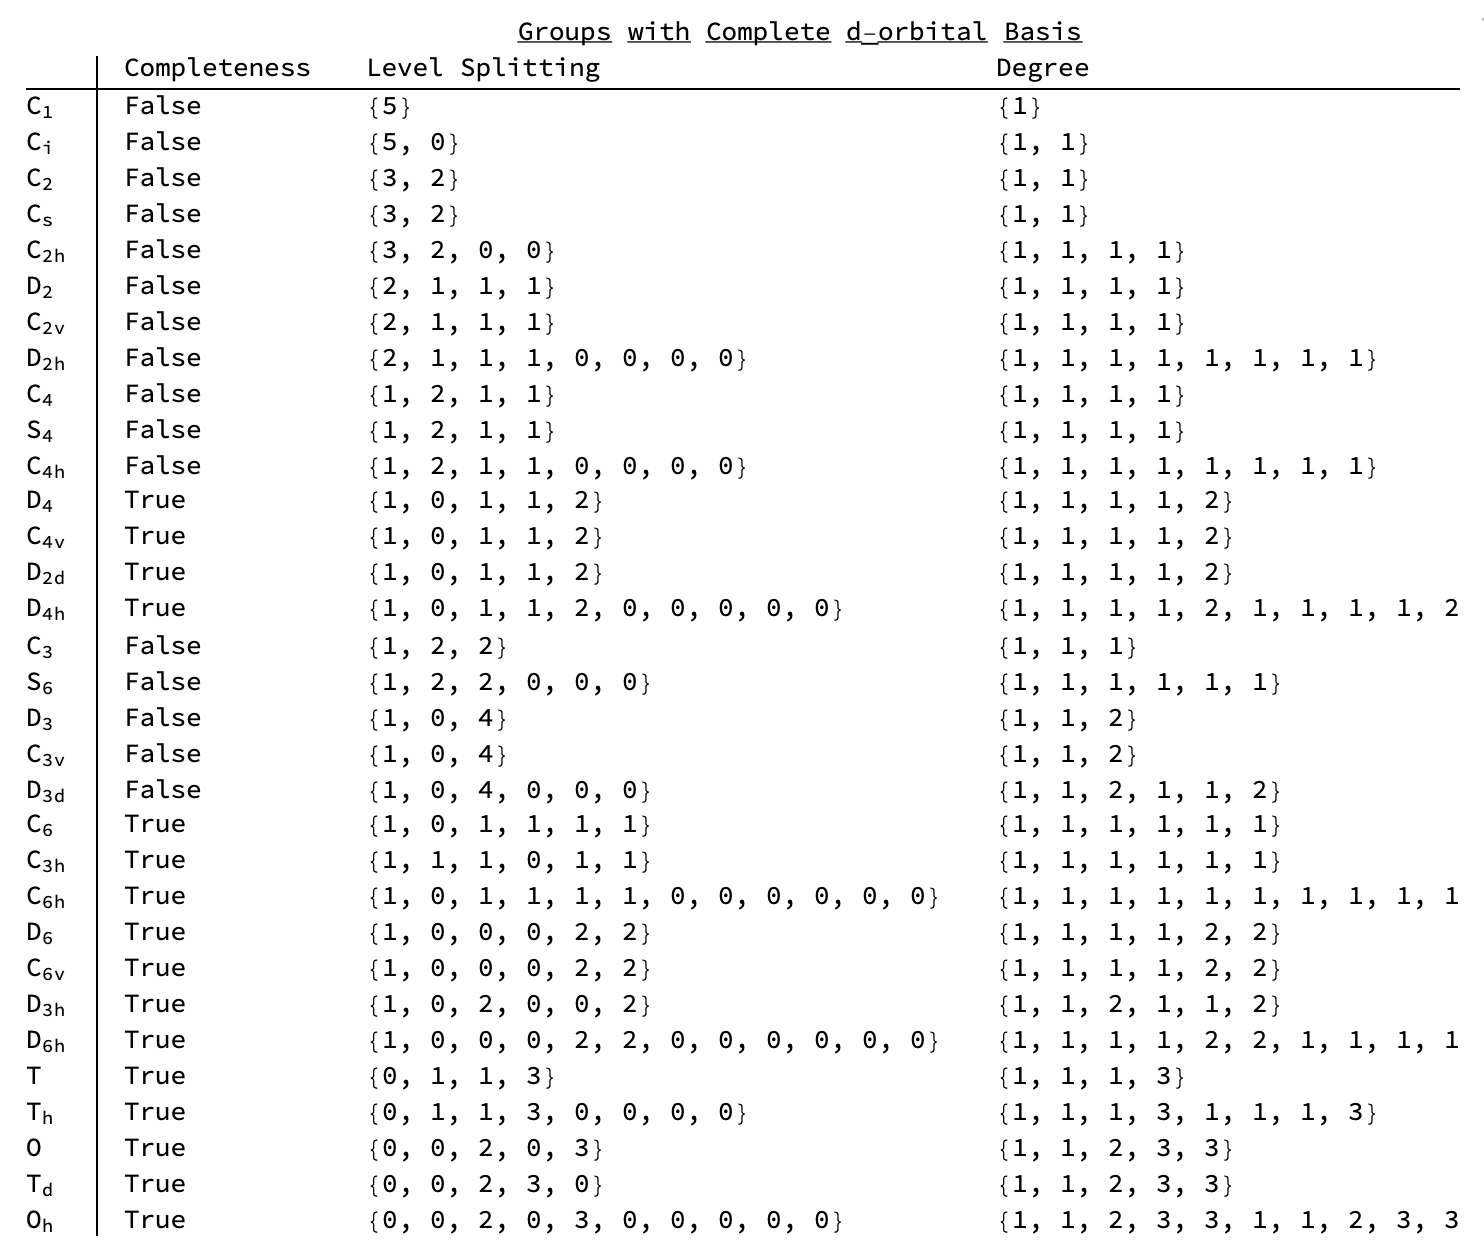

In [ ]:
def GenAList(Group):
    '''
    
    '''
    from sympy import symbols
    
    aList = []
    for idx in np.arange(len(Group.Classes)):
        aList.append(symbols(''.join(['a_',str(int(idx+1))])))
    return aList

def ContinuousCharacters(l, alpha):
    '''
    ContinuousCharacters(l,alpha) finds the character of the
    continuous rotation of angle alpha and angular momentum l
    '''
    from sympy import limit, sin, symbols
    x = symbols('x')
    
    return limit(sin((l+1/2)*x)/sin(1/2*x), x, alpha)

def GroupPhiAngle(Group):
    '''
    EulerAngles(Group) returns the principle angle for each conjugacy
    class for crystallographic point group G. These are extracted from
    the parameter tables that are loaded.
    '''
    return np.array(Group.ParameterTable)[:,4].tolist()

aList = GenAList(CPG.Groups[8])

Short digression into calculation of the crystal field splitting for any orbital.

In [ ]:
def FindSplittingReps(Group, orbital, PrintString = True):
    '''
    This function reproduces Table 2.7 in Jon's Thesis. Mathematica has 
    changed the order of the class elements and it is no longer self consistent
    with itself so it gives errors. 
    '''
    from scipy.linalg import solve
    
    if isinstance(orbital,str):
        if orbital == 's':
            orbital = 0
        elif orbital == 'p':
            orbital = 1
        elif orbital == 'd':
            orbital = 2
        elif orbital == 'f':
            orbital = 3
        else:
            print('ERROR: Orbital does not exist! Please choose one of s,p,d, or f orbitals')
    
    ClsIdx = (np.cumsum(Group.ClassSize)-1).tolist()
    ParTable = np.array(Group.ParameterTable)[ClsIdx,4].tolist()
    Chi_l = np.zeros((len(ParTable),))
    for rpIdx in np.arange(len(ParTable)):
        Chi_l[rpIdx] = ContinuousCharacters(orbital, ParTable[rpIdx])
    
    
    x = solve(np.array(Group.CharacterTable).T, Chi_l)
    x[np.abs(x)<1E-10] = 0
    
    Degen = np.round(np.abs(x)).flatten().astype(int)
    mask = Degen>0
    
    if PrintString == True:
        SplittingString = ''
        for irr in np.arange(len(Group.IrrReps)):
            if Degen[irr] != 0:
                if Degen[irr] == 1:
                    tmpStr = Group.IrrReps[irr]
                else:
                    tmpStr = ''.join([str(Degen[irr]),Group.IrrReps[irr]])
                SplittingString = '+'.join([SplittingString,tmpStr])
        
        print(Group.PointGroupLabel,'\t',SplittingString[1:],'\t',np.array(Group.RepresentationDegrees)[mask])

    return #np.array(Group.IrrReps).dot()

def c_STK(Group, IrrRep, l):
    h = len(Group.Elements)
    
    ClsIdx = Group.elementPositions()#(np.cumsum(Group.ClassSize)-1).tolist()
    ParTable = np.array(Group.ParameterTable)[ClsIdx,4]
    Chi_l = np.zeros((len(ParTable),))
    
    rpIdx = Group.IrrReps.index(IrrRep)
    Chi_k = np.array(Group.CharacterTable)[rpIdx,:]
    
    for clsIdx in np.arange(len(ParTable)):
        Chi_l[clsIdx] = ContinuousCharacters(l, ParTable[clsIdx])
        print('%s \t alpha: %s \t chi: %s'%(Group.Classes[clsIdx],ParTable[clsIdx],Chi_l[clsIdx]))
    
    print(Group.ClassSize)
    print(Chi_k)
    print(Chi_l)
    return 1/h*(Group.ClassSize*Chi_k).dot(Chi_l)

def CharactersSquares(Group, Gamma):
    '''
    CharactersSquares(Group, Gamma) returns the characters of the \
    squared classes from ClassesSquared
    '''
    if isinstance(Gamma,str):
        Gamma = Group.IrrReps.index(Gamma)
    IrrRepChar = np.array(Group.CharacterTable[Gamma])
    CharSqrs = []
    for cls in ClassesSquared(Group):
        CharSqrs.append(IrrRepChar[cls])
    return CharSqrs

def SymmetricProduct(Group, Gamma):
    "SymmetricProduct(Group,Gamma) returns the direct sum \
    decomposition of the symmetric product of representation \
    Gamma"
    from scipy.linalg import solve
    if isinstance(Gamma,str):
        Gamma = Group.IrrReps.index(Gamma)
    
    x = solve(np.transpose(Group.CharacterTable),1/2*(np.array(Group.CharacterTable[Gamma])**2 + CharactersSquares(Group, Gamma)))

    if np.iscomplex(x).any():
        x_real = np.real(x)
        x_imag = np.imag(x)
        x_real[np.abs(x_real)<1E-10] = 0
        x_imag[np.abs(x_imag)<1E-10] = 0
        x = x_real+x_imag*1j
    else:
        x[np.abs(x)<1E-10] = 0

    return np.argwhere(x==1).flatten().tolist()

def AntiSymmetricProduct(Group, Gamma):
    "SymmetricProduct(Group,Gamma) returns the direct sum \
    decomposition of the antisymmetric product of representation \
    Gamma"
    from scipy.linalg import solve
    if isinstance(Gamma,str):
        Gamma = Group.IrrReps.index(Gamma)
    
    x = solve(np.transpose(Group.CharacterTable),1/2*(np.array(Group.CharacterTable[Gamma])**2 - CharactersSquares(Group, Gamma)))

    if np.iscomplex(x).any():
        x_real = np.real(x)
        x_imag = np.imag(x)
        x_real[np.abs(x_real)<1E-10] = 0
        x_imag[np.abs(x_imag)<1E-10] = 0
        x = x_real+x_imag*1j
    else:
        x[np.abs(x)<1E-10] = 0

    return np.argwhere(x==1).flatten().tolist()

def ClassesSquared(Group, PrintTable = False): 
    '''ClassesSquared(G) returns the class that the square of each class \
    belongs to'''
    MatReps = np.array(Group.SpaceGroupMatrices)[Group.elementPositions()]
    SqrMat = np.linalg.matrix_power(MatReps,2)
    IdxList = np.tile(np.arange(len(Group.SpaceGroupMatrices)),len(SqrMat))
    BoolList = [np.allclose(x,y) for x in SqrMat for y in Group.SpaceGroupMatrices]
    ClassSquared = sym.Matrix(IdxList[BoolList])
    for x,y in zip(np.arange(Group.GroupOrderh),np.repeat(np.arange(len(Group.Classes)),Group.ClassSize)):
        ClassSquared = ClassSquared.replace(x,y)
    return np.array(ClassSquared).flatten().tolist()

def ThresholdCoefficients(entry):
    Dict = entry.as_coefficients_dict()
    
    simplified_entry = 0
    for coeff in Dict.keys():
        if abs(Dict[coeff])<1e-10:
            Dict[coeff] = 0
        simplified_entry = simplified_entry + Dict[coeff]*coeff
    return simplified_entry

def GroupSymmetricSquares(Group, ReturnLabels = False): 
    '''
    GroupSymmetricSquares(G) returns the list of representations in the \
    symmetric squares
    '''
    Results = []
    if ReturnLabels == True:
        for Gamma in Group.IrrReps:
            Results.append((np.array(Group.IrrReps)[SymmetricProduct(Group, Gamma)]).tolist())
    else:
        for Gamma in Group.IrrReps:
            Results.append(SymmetricProduct(Group, Gamma))
    return Results

def GroupAntiSymmetricSquares(Group, ReturnLabels = False): 
    '''
    GroupSymmetricSquares(G) returns the list of representations in the \
    symmetric squares
    '''
    Results = []
    if ReturnLabels == True:
        for Gamma in Group.IrrReps:
            Results.append((np.array(Group.IrrReps)[AntiSymmetricProduct(Group, Gamma)]).tolist())
    else:
        for Gamma in Group.IrrReps:
            Results.append(AntiSymmetricProduct(Group, Gamma))
    return Results

def GetComponents(Group):
    '''
    #GetComponents(Group) returns the names of the components for each 
    #representation of crystallographc point group Group
    '''
    Chi_0 = np.array(Group.CharacterTable)[:,0]
    Gamma_0 = Group.IrrReps
    
    componentList = []
    for comp in np.arange(len(Chi_0)):
        irrrep = Gamma_0[comp]
        switcher={
        1: ''.join(['a_{',irrrep,'}']),
        2: [''.join(['u_{',irrrep,'}']),''.join(['v_{',irrrep,'}'])],
        3: [''.join(['x_{',irrrep]),''.join(['y_{',irrrep,'}']),''.join(['z_{',irrrep,'}'])],
        }
        componentList.append(switcher.get(Chi_0[comp], "ERROR"))
    return componentList

def ComponentIdx(Group):
    '''
    #ComponentIdx(Group) returns a list of component indices 
    #partitioned by representation
    '''
    CompLen = list(map(np.shape, GetComponents(Group)))
    for idx in np.arange(len(CompLen)):
        ent = CompLen[idx]
        if ent == ():
            CompLen[idx] = 1
        else:
            CompLen[idx] = ent[0]
            
    AccComList = np.cumsum(CompLen)

    return [np.arange(x,y+0.1).astype(int).tolist() for x,y in zip((np.insert(AccComList[0:-1]+1,0,1)).astype(int),AccComList)]

def Representation2Components(Group, Gamma):
    '''
    Representation2Components(Group, Gamma) returns the \
    components of the representation Gamma in the group Group
    '''
    if isinstance(Gamma,str):
        Gamma = Group.IrrReps.index(Gamma)
        
    return ComponentIdx(Group)[Gamma]

def Component2Representation(Group, Component):
    '''
    Component2Representation(Group, Component) returns the representation 
    to which the component (Component) belongs
    '''
    RepList = []
    compGrpIdx = ComponentIdx(Group)
    for CompSet in compGrpIdx:
        RepList.append(np.isin(Component,CompSet).flatten()[0])
    # Mathematica code does something convoluted with below:
    #return #(np.array(compGrpIdx)[np.array(RepList)]).tolist()[0]
    # I've chosen to skip this
    return np.where(RepList)[0]

def GetPermutationSign(Group, Gamma): 
    '''
    GetPermutationSign(Group, Gamma) returns [1] if the \
    representation Gamma is in the symmetric squares, [-1] if \
    it is in the antisymmetric squares, [1,-1] if it is in both and [1] \
    if it is in \neither.
    '''
    if isinstance(Gamma,str):
        Gamma = Group.IrrReps.index(Gamma)
    
    SymList = GroupSymmetricSquares(Group)
    ASymList = GroupAntiSymmetricSquares(Group)
    SymBool = 'Null'
    ASymBool = 'Null'
    
    for idx in np.arange(len(SymList)):
        if np.isin(Gamma,SymList[idx]).flatten()[0]:
            SymBool = True
        if np.isin(Gamma,ASymList[idx]).flatten()[0]:
            ASymBool = True
    PermList = []
    if SymBool == True: 
        PermList.append(1)
    if ASymBool == True: 
        PermList.append(-1)
    if PermList == []:
        PermList.append(1)
    return PermList

def GetRepresentationEnergy(Group, l=4, orbital = 'd'):
    '''
    GetRepresentationEnergy(Group) gives the energy for each \
    representation of point group G assuming d-orbitals
    '''
    EigenVals, eVec, repIdx, srtIdx = SingleElectronSplitting(Group, l=4, orbital = 'd', debug=False)
    Results = np.array(EigenVals)[srtIdx]
    return list(dict.fromkeys(Results))

for grp in np.arange(32):
    #print(CPG.Groups[grp].PointGroupLabel)
    FindSplittingReps(CPG.Groups[grp], 'd')
    
#c_STK(CPG.Groups[29],CPG.Groups[29].IrrReps[2],2)

In [ ]:
for Group in CPG.Groups[11:]:
    print(Group.PointGroupLabel,GetRepresentationEnergy(Group))